<div style="text-align:right;">Justine Charrel - Master 1 Internship</div>

This script calculate the differences between the radiosoundings of ERA5 and them of MOSAiC. It plots their distribution and profiles.

### IMPORT

In [1]:
from netCDF4 import Dataset as ncfile
import numpy as np
from netCDF4 import num2date
import matplotlib.dates as dates
import statistics
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import cmath
import numpy.ma as ma

### READ DATA

In [2]:
ppidir = '/lustre/storeB/users/justinec/master_internship/data/ERA5_MOSAiC/'
data_link  = ppidir + 'concatenated_ERA5_MOSAiC.nc'

data = ncfile(data_link,'r')    #dataset of radiosoundings of MOSAiC and ERA5

In [3]:
pres = data.variables['pres'][:]
lat = data.variables['lat_mosaic'][:] 
lon = data.variables['lon_mosaic'][:]
time = data.variables['time_mosaic'][:]
era5_temp = data.variables['temp_era5'][:]
era5_rh = data.variables['rh_era5'][:]
era5_sh = data.variables['sh_era5'][:]
era5_wdir = data.variables['wdir_era5'][:]
era5_wspeed = data.variables['wspeed_era5'][:]
mosaic_temp = data.variables['temp_mosaic'][:]
mosaic_rh = data.variables['rh_mosaic'][:]
mosaic_sh = data.variables['sh_mosaic'][:]
mosaic_wdir = data.variables['wdir_mosaic'][:]
mosaic_wspeed = data.variables['wspeed_mosaic'][:]

### REPLACE MASKED/NAN VALUES BY INTERPOLATION BETWEEN NEAREST VALUES

In [4]:
mosaic_rh = np.ma.masked_object(mosaic_rh, mosaic_rh[559][11]) # mask outlier value

In [5]:
def replacenan(var) :
    new_var = np.zeros((len(var),len(pres)))
    for i in range(0,len(var)) :
        for j in range(0,len(var[i])) :
            if ma.getmask(var)[i][j] == True :
                #print('masked value in {}, {}'.format(i,j))
                if j == 28 :
                    #print('value in j-1 : {}, value in j-2 : {}'.format(var[i][j-1],var[i][j-2]))
                    new_var[i][j] = var[i][j-1]+(var[i][j-1]-var[i][j-2])
                    #print('new value :', new_var[i][j])
                else :
                    #print(var[i][j-1],var[i][j+1])
                    new_var[i][j] = np.mean([var[i][j-1],var[i][j+1]])
                    #print(new_var[i][j])
            else :
                new_var[i][j] = var[i][j]  
    return new_var

In [6]:
new_mosaic_temp = replacenan(mosaic_temp)
new_mosaic_rh = replacenan(mosaic_rh)
new_mosaic_wdir = replacenan(mosaic_wdir)
new_mosaic_wspeed = replacenan(mosaic_wspeed)

#Verify there is no more masked/nan values
print('temp nan values :', ma.count_masked(new_mosaic_temp))
print('rh nan values :', ma.count_masked(new_mosaic_rh))
print('wdir nan values :', ma.count_masked(new_mosaic_wdir))
print('wspeed nan values :', ma.count_masked(new_mosaic_wspeed))

temp nan values : 0
rh nan values : 0
wdir nan values : 0
wspeed nan values : 0


### CALCULATE THE BIASES BETWEEN ERA5 AND MOSAiC

In [7]:
temp_bias = era5_temp-new_mosaic_temp
rh_bias = era5_rh-new_mosaic_rh
sh_bias = era5_sh-mosaic_sh
wspeed_bias = era5_wspeed-new_mosaic_wspeed

In [8]:
# need to use direction errors
wdir_bias = era5_wdir-new_mosaic_wdir
for i in range(len(wdir_bias)) :
    for n in range(len(wdir_bias[i])) :
        if wdir_bias[i][n] > 180 :
            wdir_bias[i][n] = wdir_bias[i][n]-360
        if wdir_bias[i][n] < -180 :
            wdir_bias[i][n] = wdir_bias[i][n]+360

### DISTRIBUTION OF THE BIASES

In [9]:
def varlevel(var) :
    var_1000 = []
    var_900 = []
    var_600 = []
    var_300 = []
    for i in range(len(var)) :
        var_1000.append(var[i][28])
        var_900.append(var[i][25])
        var_600.append(var[i][12])
        var_300.append(var[i][0])
    return(var_1000,var_900,var_600,var_300)

In [10]:
temp_bias_1000, temp_bias_900, temp_bias_600, temp_bias_300 = varlevel(temp_bias)
rh_bias_1000, rh_bias_900, rh_bias_600, rh_bias_300 = varlevel(rh_bias)
sh_bias_1000, sh_bias_900, sh_bias_600, sh_bias_300 = varlevel(sh_bias)
wdir_bias_1000, wdir_bias_900, wdir_bias_600, wdir_bias_300 = varlevel(wdir_bias)
wspeed_bias_1000, wspeed_bias_900, wspeed_bias_600, wspeed_bias_300 = varlevel(wspeed_bias)

In [11]:
def plotdistribution() :
    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
                  'legend.title_fontsize':17, 'figure.titlesize':25}
    plt.rcParams.update(parameters)
    fig = plt.figure(figsize=(19,10))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)
    sns.histplot(temp_bias_300, binrange=(-8,8), binwidth=0.1, label='300 hPa', ax=ax1, alpha=0.4, color='purple')
    sns.histplot(temp_bias_600, binrange=(-8,8), binwidth=0.1, label='600 hPa', ax=ax1, alpha=0.4, color='yellow')
    sns.histplot(temp_bias_900, binrange=(-8,8), binwidth=0.1, label='900 hPa', ax=ax1, alpha=0.4, color='green')
    sns.histplot(temp_bias_1000, binrange=(-8,8), binwidth=0.1, label='1000 hPa', ax=ax1, alpha=0.4, color='red')
    ax1.set(ylabel='Number of occurences', xlabel='(a) Temperature [$K$]')
    ax1.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    ax1.set_ylim(0,200)
    ax1.legend()

    sns.histplot(rh_bias_300, binrange=(-50,80), binwidth=1, label='300 hPa', ax=ax2, alpha=0.4, color='purple')
    sns.histplot(rh_bias_600, binrange=(-50,80), binwidth=1, label='600 hPa', ax=ax2, alpha=0.4, color='yellow')
    sns.histplot(rh_bias_900, binrange=(-50,80), binwidth=1, label='900 hPa', ax=ax2, alpha=0.4, color='green')
    sns.histplot(rh_bias_1000, binrange=(-50,80), binwidth=1, label='1000 hPa',ax=ax2, alpha=0.4, color='red')
    ax2.set(ylabel='', xlabel='(b) Relative humidity [$\%$]')
    ax2.set_ylim(0,130)
    ax2.legend()
    
    sns.histplot(sh_bias_300, binrange=(-1,1), binwidth=0.01, label='300 hPa', ax=ax3, alpha=0.4, color='purple')
    sns.histplot(sh_bias_600, binrange=(-1,1), binwidth=0.01, label='600 hPa', ax=ax3, alpha=0.4, color='yellow')
    sns.histplot(sh_bias_900, binrange=(-1,1), binwidth=0.01, label='900 hPa', ax=ax3, alpha=0.4, color='green')
    sns.histplot(sh_bias_1000, binrange=(-1,1), binwidth=0.01, label='1000 hPa',ax=ax3, alpha=0.4, color='red')
    ax3.set(ylabel='', xlabel='(c) Specific humidity [$g.kg^{-1}$]')
    ax3.set_yticks(np.arange(0,701,100))
    ax3.set_ylim(0,720)
    ax3.legend()

    sns.histplot(wdir_bias_300, binrange=(-150,150), binwidth=2, label='300 hPa', ax=ax4, alpha=0.4, color='purple')
    sns.histplot(wdir_bias_600, binrange=(-150,150), binwidth=2, label='600 hPa', ax=ax4, alpha=0.4, color='yellow')
    sns.histplot(wdir_bias_900, binrange=(-150,150), binwidth=2, label='900 hPa', ax=ax4, alpha=0.4, color='green')
    sns.histplot(wdir_bias_1000, binrange=(-150,150), binwidth=2, label='1000 hPa', ax=ax4, alpha=0.4, color='red')
    ax4.set(ylabel='Number of occurences', xlabel='(d) Wind direction [$°$]')
    ax4.set_xticks([-150, -100, -50, 0, 50, 100, 150])
    ax4.set_ylim(0,200)
    ax4.legend()

    sns.histplot(wspeed_bias_300, binrange=(-15,15), binwidth=0.2, label='300 hPa', ax=ax5, alpha=0.4, color='purple')
    sns.histplot(wspeed_bias_600, binrange=(-15,15), binwidth=0.2, label='600 hPa', ax=ax5, alpha=0.4, color='yellow')
    sns.histplot(wspeed_bias_900, binrange=(-15,15), binwidth=0.2, label='900 hPa', ax=ax5, alpha=0.4, color='green')
    sns.histplot(wspeed_bias_1000, binrange=(-15,15), binwidth=0.2, label='1000 hPa', ax=ax5, alpha=0.4, color='red')
    ax5.set(ylabel='', xlabel='(e) Wind speed [$m.s^{-1}$]')
    ax5.set_xticks([-15, -10, -5, 0, 5, 10, 15])
    ax5.set_ylim(0,100)
    ax5.legend()
    
    fig.tight_layout()
    #fig.suptitle('Distribution of differences betweeen ERA5 and MOSAiC')
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
    plt.savefig(path_fig+'fig_biases_distribution.png',dpi=300,facecolor='white',transparent=False)

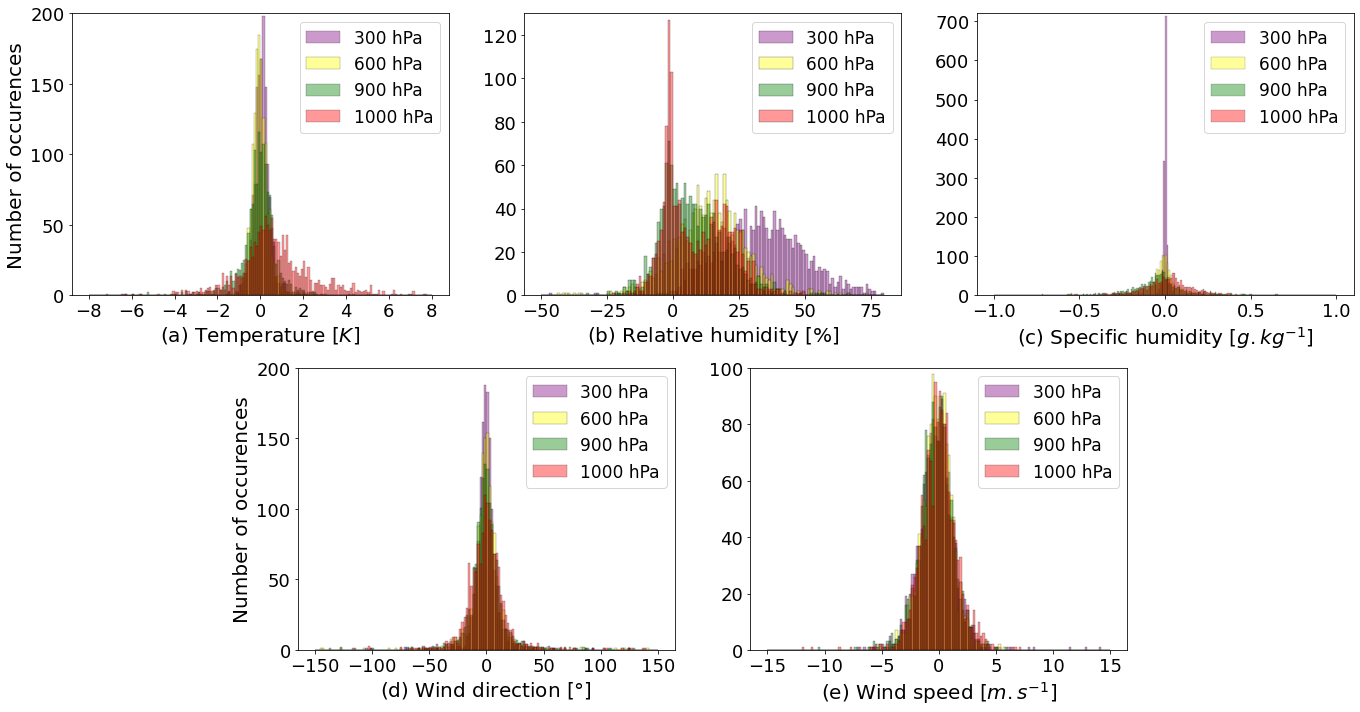

In [12]:
plotdistribution()

In [50]:
import string

In [61]:
def plotdistribution() :
    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
                  'legend.title_fontsize':17, 'figure.titlesize':25}
    plt.rcParams.update(parameters)
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0), colspan=2)
    ax2 = plt.subplot2grid((2,4), (0,2), colspan=2)
    ax3 = plt.subplot2grid((2,4), (1,1), colspan=2)
    
    sns.histplot(temp_bias_300, binrange=(-8,8), binwidth=0.1, label='300 hPa', ax=ax1, alpha=0.4, color='purple')
    sns.histplot(temp_bias_600, binrange=(-8,8), binwidth=0.1, label='600 hPa', ax=ax1, alpha=0.4, color='yellow')
    sns.histplot(temp_bias_900, binrange=(-8,8), binwidth=0.1, label='900 hPa', ax=ax1, alpha=0.4, color='green')
    sns.histplot(temp_bias_1000, binrange=(-8,8), binwidth=0.1, label='1000 hPa', ax=ax1, alpha=0.4, color='red')
    ax1.set(ylabel='Number of occurences', xlabel='Temperature [$K$]')
    ax1.set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
    ax1.set_ylim(0,200)
    ax1.text(0.01, 0.9, 'A', transform=ax1.transAxes, size=25, weight='bold')
    ax1.legend()

    sns.histplot(rh_bias_300, binrange=(-50,80), binwidth=1, label='300 hPa', ax=ax2, alpha=0.4, color='purple')
    sns.histplot(rh_bias_600, binrange=(-50,80), binwidth=1, label='600 hPa', ax=ax2, alpha=0.4, color='yellow')
    sns.histplot(rh_bias_900, binrange=(-50,80), binwidth=1, label='900 hPa', ax=ax2, alpha=0.4, color='green')
    sns.histplot(rh_bias_1000, binrange=(-50,80), binwidth=1, label='1000 hPa',ax=ax2, alpha=0.4, color='red')
    ax2.set(ylabel='', xlabel='Relative humidity [$\%$]')
    ax2.text(0.01, 0.9, 'B', transform=ax2.transAxes, size=25, weight='bold')
    ax2.set_ylim(0,130)
    ax2.legend()
    
    sns.histplot(sh_bias_300, binrange=(-1,1), binwidth=0.01, label='300 hPa', ax=ax3, alpha=0.4, color='purple')
    sns.histplot(sh_bias_600, binrange=(-1,1), binwidth=0.01, label='600 hPa', ax=ax3, alpha=0.4, color='yellow')
    sns.histplot(sh_bias_900, binrange=(-1,1), binwidth=0.01, label='900 hPa', ax=ax3, alpha=0.4, color='green')
    sns.histplot(sh_bias_1000, binrange=(-1,1), binwidth=0.01, label='1000 hPa',ax=ax3, alpha=0.4, color='red')
    ax3.set(ylabel='', xlabel='Specific humidity [$g.kg^{-1}$]')
    ax3.text(0.01, 0.9, 'C', transform=ax3.transAxes, size=25, weight='bold')
    ax3.set_yticks(np.arange(0,701,100))
    ax3.set_ylim(0,720)
    ax3.legend()
    
    fig.tight_layout()
    #fig.suptitle('Distribution of differences betweeen ERA5 and MOSAiC')
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
    plt.savefig(path_fig+'fig_biases_distribution_3.png',dpi=300,facecolor='white',transparent=False)

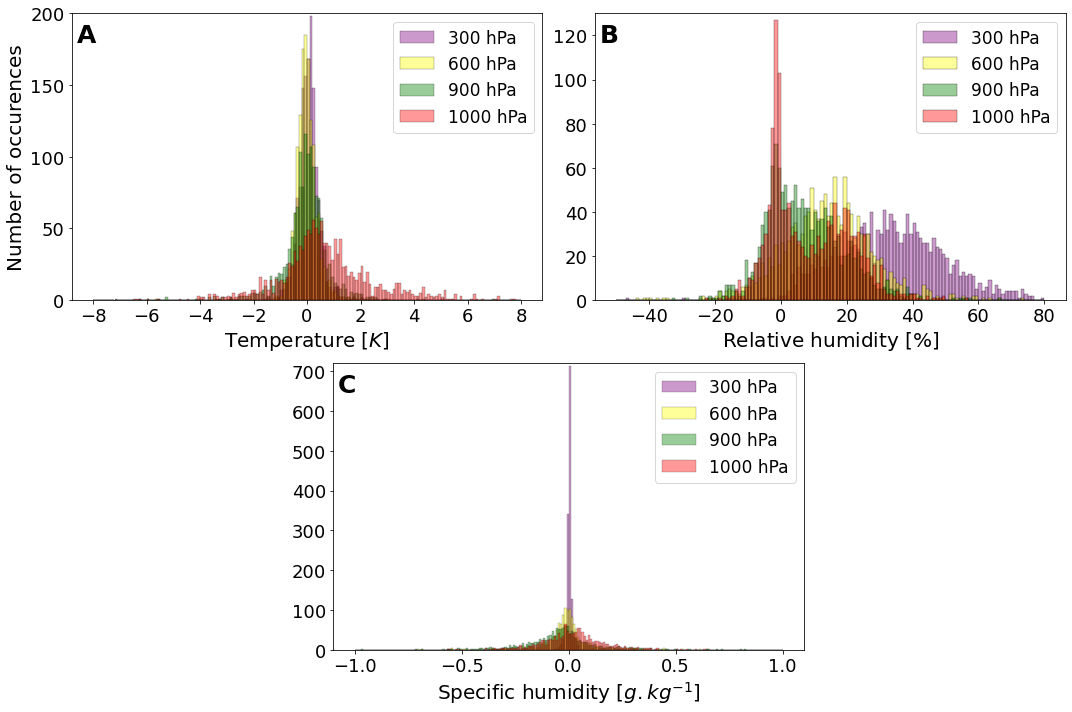

In [62]:
plotdistribution()

### DISTRIBUTION PER VARIABLE

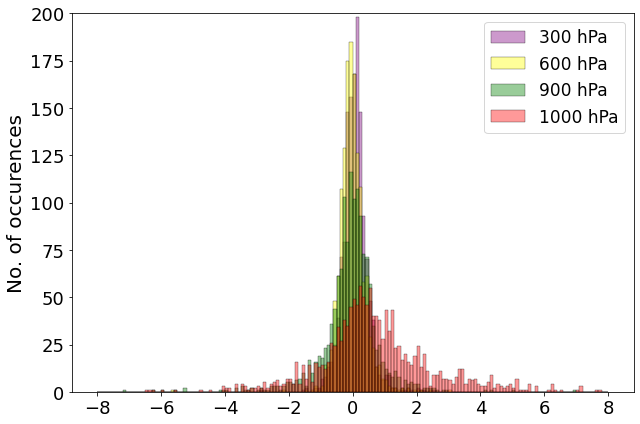

In [13]:
parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
              'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig = plt.figure(figsize=(9,6))
sns.histplot(temp_bias_300, binrange=(-8,8), binwidth=0.1, label='300 hPa', alpha=0.4, color='purple')
sns.histplot(temp_bias_600, binrange=(-8,8), binwidth=0.1, label='600 hPa', alpha=0.4, color='yellow')
sns.histplot(temp_bias_900, binrange=(-8,8), binwidth=0.1, label='900 hPa', alpha=0.4, color='green')
ax = sns.histplot(temp_bias_1000, binrange=(-8,8), binwidth=0.1, label='1000 hPa', alpha=0.4, color='red')
ax.set(ylabel='No. of occurences')
ax.set_ylim(0,200)
plt.legend()

fig.tight_layout()
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
plt.savefig(path_fig+'temp_biases_distribution.png',dpi=300,facecolor='white',transparent=False)

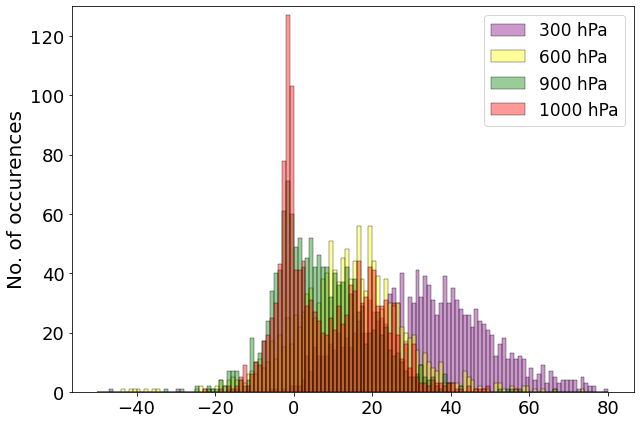

In [14]:
parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
              'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig = plt.figure(figsize=(9,6))
sns.histplot(rh_bias_300, binrange=(-50,80), binwidth=1, label='300 hPa', alpha=0.4, color='purple')
sns.histplot(rh_bias_600, binrange=(-50,80), binwidth=1, label='600 hPa', alpha=0.4, color='yellow')
sns.histplot(rh_bias_900, binrange=(-50,80), binwidth=1, label='900 hPa', alpha=0.4, color='green')
ax = sns.histplot(rh_bias_1000, binrange=(-50,80), binwidth=1, label='1000 hPa', alpha=0.4, color='red')
ax.set(ylabel='No. of occurences')
ax.set_ylim(0,130)
ax.set_xticks([-40,-20,0,20,40,60,80])
plt.legend()

fig.tight_layout()
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
plt.savefig(path_fig+'rh_biases_distribution.png',dpi=300,facecolor='white',transparent=False)

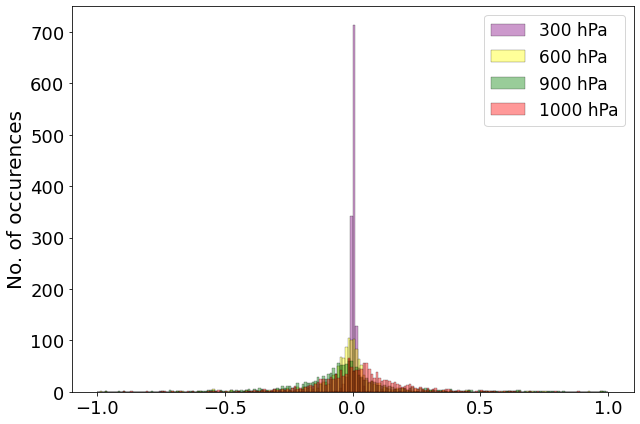

In [15]:
parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
              'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig = plt.figure(figsize=(9,6))
sns.histplot(sh_bias_300, binrange=(-1,1), binwidth=0.01, label='300 hPa', alpha=0.4, color='purple')
sns.histplot(sh_bias_600, binrange=(-1,1), binwidth=0.01, label='600 hPa', alpha=0.4, color='yellow')
sns.histplot(sh_bias_900, binrange=(-1,1), binwidth=0.01, label='900 hPa', alpha=0.4, color='green')
ax = sns.histplot(sh_bias_1000, binrange=(-1,1), binwidth=0.01, label='1000 hPa', alpha=0.4, color='red')
ax.set(ylabel='No. of occurences')
ax.set_xticks([-1,-0.5,0,0.5,1])
plt.legend()

fig.tight_layout()
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
plt.savefig(path_fig+'sh_biases_distribution.png',dpi=300,facecolor='white',transparent=False)

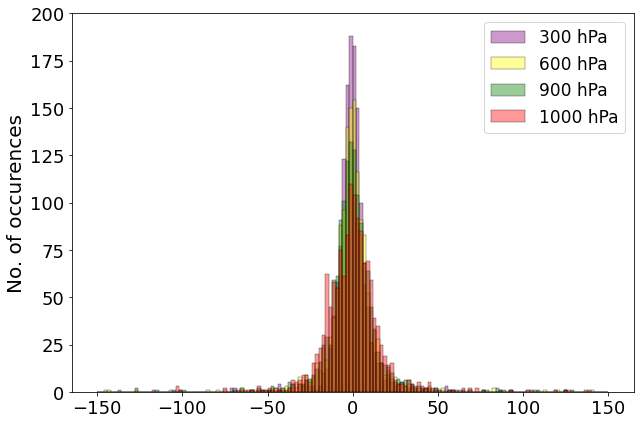

In [16]:
parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
              'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig = plt.figure(figsize=(9,6))
sns.histplot(wdir_bias_300, binrange=(-150,150), binwidth=2, label='300 hPa', alpha=0.4, color='purple')
sns.histplot(wdir_bias_600, binrange=(-150,150), binwidth=2, label='600 hPa', alpha=0.4, color='yellow')
sns.histplot(wdir_bias_900, binrange=(-150,150), binwidth=2, label='900 hPa', alpha=0.4, color='green')
ax = sns.histplot(wdir_bias_1000, binrange=(-150,150), binwidth=2, label='1000 hPa', alpha=0.4, color='red')
ax.set(ylabel='No. of occurences')
ax.set_xticks([-150, -100, -50, 0, 50, 100, 150])
ax.set_ylim(0,200)
plt.legend()

fig.tight_layout()
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
plt.savefig(path_fig+'wdir_biases_distribution.png',dpi=300,facecolor='white',transparent=False)

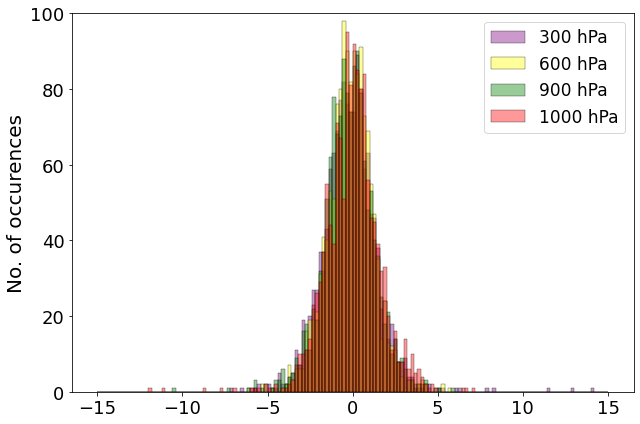

In [17]:
parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
              'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig = plt.figure(figsize=(9,6))
sns.histplot(wspeed_bias_300, binrange=(-15,15), binwidth=0.2, label='300 hPa', alpha=0.4, color='purple')
sns.histplot(wspeed_bias_600, binrange=(-15,15), binwidth=0.2, label='600 hPa', alpha=0.4, color='yellow')
sns.histplot(wspeed_bias_900, binrange=(-15,15), binwidth=0.2, label='900 hPa', alpha=0.4, color='green')
ax = sns.histplot(wspeed_bias_1000, binrange=(-15,15), binwidth=0.2, label='1000 hPa', alpha=0.4, color='red')
ax.set(ylabel='No. of occurences')
ax.set_xticks([-15, -10, -5, 0, 5, 10, 15])
ax.set_ylim(0,100)
plt.legend()
    
fig.tight_layout()
path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
plt.savefig(path_fig+'wspeed_biases_distribution.png',dpi=300,facecolor='white',transparent=False)

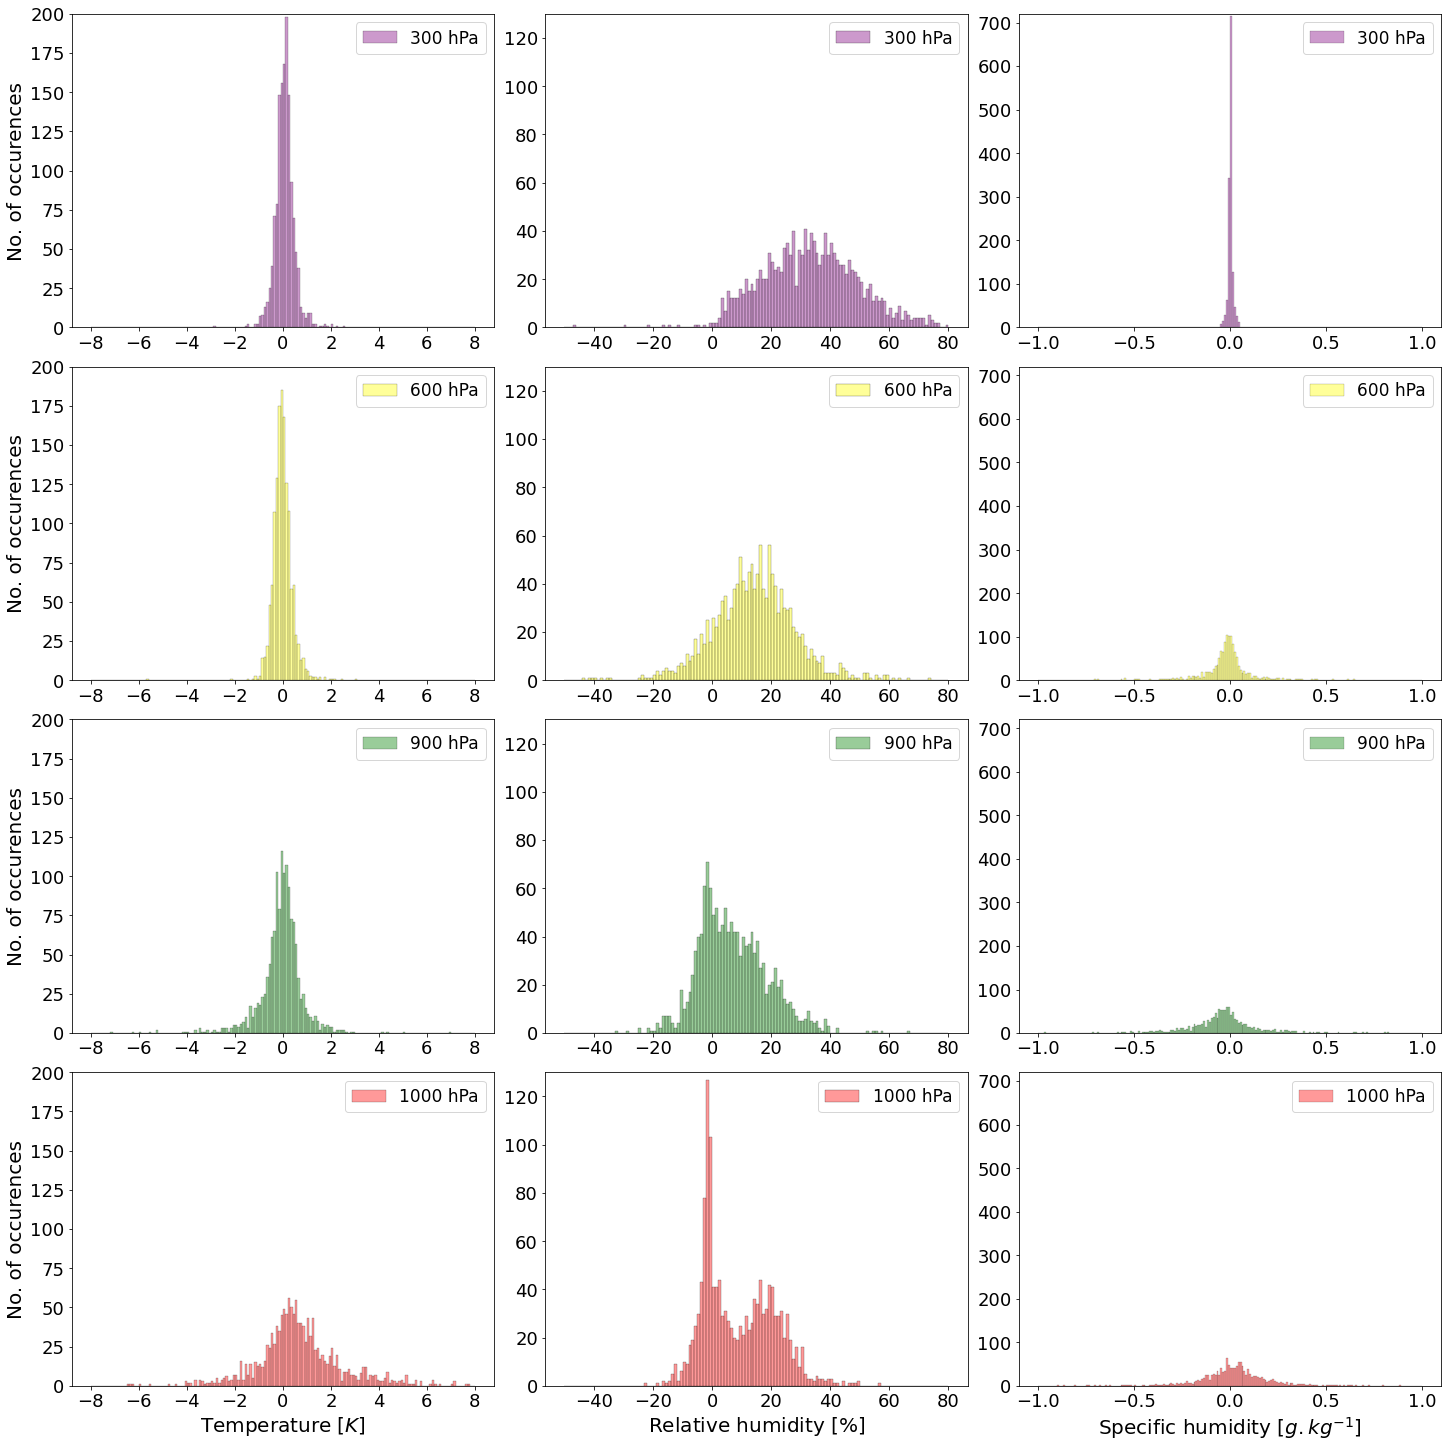

In [18]:
parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
              'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig, axs = plt.subplots(4,3,figsize=(20,20), constrained_layout=True)  
sns.histplot(temp_bias_300, binrange=(-8,8), binwidth=0.1, label='300 hPa', ax=axs[0,0], alpha=0.4, color='purple')
sns.histplot(temp_bias_600, binrange=(-8,8), binwidth=0.1, label='600 hPa', ax=axs[1,0], alpha=0.4, color='yellow')
sns.histplot(temp_bias_900, binrange=(-8,8), binwidth=0.1, label='900 hPa', ax=axs[2,0], alpha=0.4, color='green')
sns.histplot(temp_bias_1000, binrange=(-8,8), binwidth=0.1, label='1000 hPa', ax=axs[3,0], alpha=0.4, color='red')

sns.histplot(rh_bias_300, binrange=(-50,80), binwidth=1, label='300 hPa', ax=axs[0,1], alpha=0.4, color='purple')
sns.histplot(rh_bias_600, binrange=(-50,80), binwidth=1, label='600 hPa', ax=axs[1,1], alpha=0.4, color='yellow')
sns.histplot(rh_bias_900, binrange=(-50,80), binwidth=1, label='900 hPa', ax=axs[2,1], alpha=0.4, color='green')
sns.histplot(rh_bias_1000, binrange=(-50,80), binwidth=1, label='1000 hPa',ax=axs[3,1], alpha=0.4, color='red')

sns.histplot(sh_bias_300, binrange=(-1,1), binwidth=0.01, label='300 hPa', ax=axs[0,2], alpha=0.4, color='purple')
sns.histplot(sh_bias_600, binrange=(-1,1), binwidth=0.01, label='600 hPa', ax=axs[1,2], alpha=0.4, color='yellow')
sns.histplot(sh_bias_900, binrange=(-1,1), binwidth=0.01, label='900 hPa', ax=axs[2,2], alpha=0.4, color='green')
sns.histplot(sh_bias_1000, binrange=(-1,1), binwidth=0.01, label='1000 hPa',ax=axs[3,2], alpha=0.4, color='red')

for i in range(0,4):
    for j in range(0,3):
        if j == 0 :
            axs[i,j].set_ylim(0,200)
            axs[i,j].set_xticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
        if j == 1 :
            axs[i,j].set_ylim(0,130)
            axs[i,j].set_xticks([-40,-20,0,20,40,60,80])
        if j == 2 :
            axs[i,j].set_ylim(0,720)
        axs[i,j].set(ylabel='')
        axs[i,j].legend()
        
axs[0,0].set(ylabel='No. of occurences')
axs[1,0].set(ylabel='No. of occurences')
axs[2,0].set(ylabel='No. of occurences')
axs[3,0].set(ylabel='No. of occurences')
axs[3,0].set_xlabel('Temperature [$K$]')
axs[3,1].set_xlabel('Relative humidity [$\%$]')
axs[3,2].set_xlabel('Specific humidity [$g.kg^{-1}$]')

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
plt.savefig(path_fig+'biases_distribution_levels.png',dpi=300,facecolor='white',transparent=False)

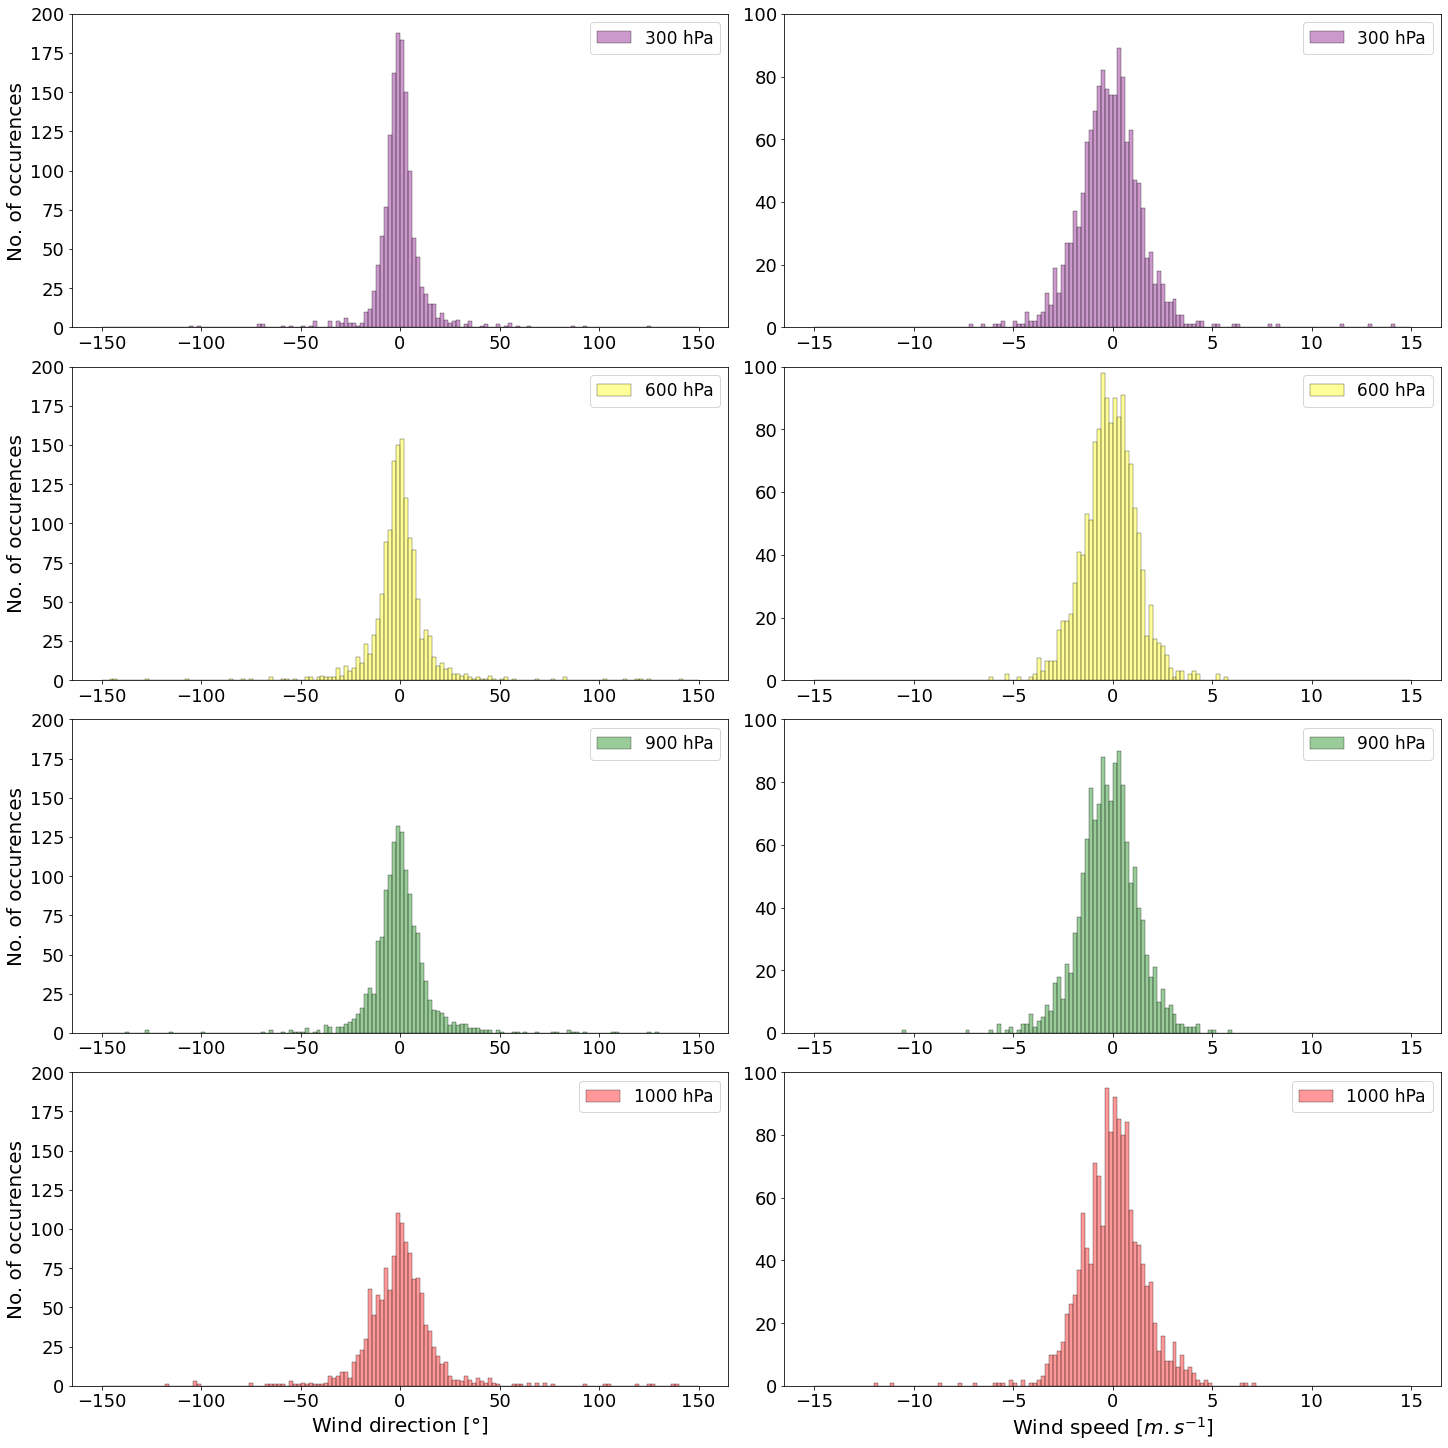

In [19]:
parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':17, 'xtick.labelsize':18, 'ytick.labelsize':18, 
              'legend.title_fontsize':17, 'figure.titlesize':25}
plt.rcParams.update(parameters)
fig, axs = plt.subplots(4,2,figsize=(20,20), constrained_layout=True)  
sns.histplot(wdir_bias_300, binrange=(-150,150), binwidth=2, label='300 hPa', ax=axs[0,0], alpha=0.4, color='purple')
sns.histplot(wdir_bias_600, binrange=(-150,150), binwidth=2, label='600 hPa', ax=axs[1,0], alpha=0.4, color='yellow')
sns.histplot(wdir_bias_900, binrange=(-150,150), binwidth=2, label='900 hPa', ax=axs[2,0], alpha=0.4, color='green')
sns.histplot(wdir_bias_1000, binrange=(-150,150), binwidth=2, label='1000 hPa', ax=axs[3,0], alpha=0.4, color='red')

sns.histplot(wspeed_bias_300, binrange=(-15,15), binwidth=0.2, label='300 hPa', ax=axs[0,1], alpha=0.4, color='purple')
sns.histplot(wspeed_bias_600, binrange=(-15,15), binwidth=0.2, label='600 hPa', ax=axs[1,1], alpha=0.4, color='yellow')
sns.histplot(wspeed_bias_900, binrange=(-15,15), binwidth=0.2, label='900 hPa', ax=axs[2,1], alpha=0.4, color='green')
sns.histplot(wspeed_bias_1000, binrange=(-15,15), binwidth=0.2, label='1000 hPa', ax=axs[3,1], alpha=0.4, color='red')

for i in range(0,4):
    for j in range(0,2):
        if j == 0 :
            axs[i,j].set_xticks([-150, -100, -50, 0, 50, 100, 150])
            axs[i,j].set_ylim(0,200)
        if j == 1 :
            axs[i,j].set_xticks([-15, -10, -5, 0, 5, 10, 15])
            axs[i,j].set_ylim(0,100)
        axs[i,j].set(ylabel='')
        axs[i,j].legend()
        
axs[0,0].set(ylabel='No. of occurences')
axs[1,0].set(ylabel='No. of occurences')
axs[2,0].set(ylabel='No. of occurences')
axs[3,0].set(ylabel='No. of occurences')
axs[3,0].set_xlabel('Wind direction [$°$]')
axs[3,1].set_xlabel('Wind speed [$m.s^{-1}$]')

path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
plt.savefig(path_fig+'wind_biases_distribution_levels.png',dpi=300,facecolor='white',transparent=False)

### CALCULATE MEAN, STANDARD DEVIATION AND CORRELATION COEFFICIENT OF EVERY PRESSURE LEVEL FOR ALL RADIOSONDES

In [14]:
def meanstd(var) :
    mean = np.mean(var, axis=0)
    std  = np.std(var, axis=0)
    return(mean,std)

In [15]:
mean_temp_bias, std_temp_bias = meanstd(temp_bias)
mean_rh_bias, std_rh_bias = meanstd(rh_bias)
mean_sh_bias, std_sh_bias = meanstd(sh_bias)
mean_wdir_bias, std_wdir_bias = meanstd(wdir_bias)
mean_wspeed_bias, std_wspeed_bias = meanstd(wspeed_bias)

In [16]:
def corr_coef(mosaic,era5) :
    mosaic_level = [] ; era5_level = [] ; r=[]
    for n in range(len(mosaic[0])) :
        for i in range(len(mosaic)) :
            mosaic_level.append(mosaic[i][n])
            era5_level.append(era5[i][n])
        r.append(np.corrcoef(mosaic_level, era5_level)[0,1])
    return r

In [18]:
mosaic_level = [] ; era5_level = [] ; r=[]
for n in range(0,1) :
    for i in range(len(new_mosaic_temp)) :
        mosaic_level.append(new_mosaic_temp[i][n])
        #print('mosaic', new_mosaic_temp[i][n])
        era5_level.append(era5_temp[i][n])
        #print('era5', era5_temp[i][n])
    r.append(np.corrcoef(mosaic_level, era5_level)[0,1])

In [19]:
r_temp = corr_coef(new_mosaic_temp,era5_temp)
r_rh = corr_coef(new_mosaic_rh,era5_rh)
r_sh = corr_coef(mosaic_sh,era5_sh)
r_wspeed = corr_coef(new_mosaic_wspeed,era5_wspeed)

In [20]:
'''This function calculate the differences between IFS and MOSAiC for a circular variable, the wind direction'''
def circular_correlation_coefficient(variable1, variable2):
        #
        var1_rad = variable1 * np.pi / 180
        var2_rad = variable2 * np.pi / 180
        #
        var1_com = np.full(np.shape(variable1), np.nan, dtype = complex)
        var2_com = np.full(np.shape(variable2), np.nan, dtype = complex)
        for i in range(0, len(variable1)):
                var1_com[i] = cmath.rect(1, var1_rad[i])
                var2_com[i] = cmath.rect(1, var2_rad[i])
        #
        var1_com_mean = np.mean(var1_com)
        var2_com_mean = np.mean(var2_com)
        #
        var1_rad_mean = cmath.phase(var1_com_mean)
        if var1_rad_mean < 0:
                var1_rad_mean = var1_rad_mean + 2 * np.pi
        #
        var2_rad_mean = cmath.phase(var2_com_mean)
        if var2_rad_mean < 0:
                var2_rad_mean = var2_rad_mean + 2 * np.pi
        #
        diff_var1 = var1_rad - var1_rad_mean
        diff_var2 = var2_rad - var2_rad_mean
        #
        Rcc = np.sum(np.sin(diff_var1) * np.sin(diff_var2)) / np.sqrt(np.sum(np.sin(diff_var1) ** 2) * np.sum(np.sin(diff_var2) ** 2))
        #
        return Rcc

In [21]:
mosaic_level = [] ; era5_level = [] ; r_wdir=[]
for n in range(len(pres)):
    for i in range(len(new_mosaic_wdir)) :
        mosaic_level.append(new_mosaic_wdir[i][n])
        era5_level.append(era5_wdir[i][n])
    mosaic_level_array = np.array(mosaic_level)
    era5_level_array = np.array(era5_level)
    r_wdir.append(circular_correlation_coefficient(mosaic_level_array, era5_level_array))

### PLOT PROFILES OF THE BIASES

In [24]:
def plotbiases() :
    
    import matplotlib.gridspec as gridspec

    parameters = {'axes.labelsize':20, 'axes.titlesize':20, 'legend.fontsize':16, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                  'legend.title_fontsize':20, 'figure.titlesize':25}
    plt.rcParams.update(parameters)

    fig, axs = plt.subplots(1,5,figsize=(30,15))
    for i in range(len(temp_bias)) :
        axs[0].plot(temp_bias[i], pres, 'gray', alpha=0.3)
    axs[0].fill_betweenx(pres, mean_temp_bias-std_temp_bias, mean_temp_bias+std_temp_bias, label='standard deviation', alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[0].plot(mean_temp_bias, pres, 'k', label = 'mean')
    axs0 = axs[0].twiny()
    axs0.plot(r_temp, pres, 'r', label = 'correlation coefficient')
    axs0.set_xlim(0.65,1)
    axs0.set_xlabel('r', color='r')
    axs0.spines['top'].set_color('red')
    axs0.tick_params(axis='x', colors='red')
    axs[0].invert_yaxis()
    axs[0].set_xlabel ('T [K]')
    axs[0].set_ylabel ('Pressure [hPa]')
    
    for i in range(len(rh_bias)) :
        axs[1].plot(rh_bias[i], pres, 'gray', alpha=0.3)
    axs[1].fill_betweenx(pres, mean_rh_bias-std_rh_bias, mean_rh_bias+std_rh_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[1].plot(mean_rh_bias, pres, 'k')
    axs1 = axs[1].twiny()
    axs1.plot(r_rh, pres, 'r')
    axs1.set_xlim(0.65,1)
    axs1.set_xlabel('r', color='r')
    axs1.spines['top'].set_color('red')
    axs1.tick_params(axis='x', colors='red')
    axs[1].invert_yaxis()
    axs[1].set_xlabel ('RH [%]')
    
    for i in range(len(sh_bias)) :
        axs[2].plot(sh_bias[i], pres, 'gray', alpha=0.3)
    axs[2].fill_betweenx(pres, mean_sh_bias-std_sh_bias, mean_sh_bias+std_sh_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[2].plot(mean_sh_bias, pres, 'k')
    axs2 = axs[2].twiny()
    axs2.plot(r_sh, pres, 'r')
    axs2.set_xlim(0,1)
    axs2.set_xlabel('r', color='r')
    axs2.spines['top'].set_color('red')
    axs2.tick_params(axis='x', colors='red')
    axs[2].invert_yaxis()
    axs[2].set_xlabel ('SH [$g.kg^{-1}$]')

    for i in range(len(wdir_bias)) :
        axs[3].plot(wdir_bias[i], pres, 'gray', alpha=0.3)
    axs[3].fill_betweenx(pres, mean_wdir_bias-std_wdir_bias, mean_wdir_bias+std_wdir_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[3].plot(mean_wdir_bias, pres, 'k')
    axs3 = axs[3].twiny()
    axs3.plot(r_wdir, pres, 'r')
    axs3.set_xlim(0.65,1)
    axs3.set_xlabel('r', color='r')
    axs3.spines['top'].set_color('red')
    axs3.tick_params(axis='x', colors='red')
    axs[3].invert_yaxis()
    axs[3].set_xlabel ('Wind direction [degree]')

    for i in range(len(wspeed_bias)) :
        axs[4].plot(wspeed_bias[i], pres, 'gray', alpha=0.3)
    axs[4].fill_betweenx(pres, mean_wspeed_bias-std_wspeed_bias, mean_wspeed_bias+std_wspeed_bias, alpha = 0.2, edgecolor='b', facecolor='b', zorder=2)
    axs[4].plot(mean_wspeed_bias, pres, 'k')
    axs4 = axs[4].twiny()
    axs4.plot(r_wspeed, pres, 'r')
    axs4.set_xlim(0.65,1)
    axs4.set_xlabel('r', color='r')
    axs4.spines['top'].set_color('red')
    axs4.tick_params(axis='x', colors='red')
    axs[4].invert_yaxis()
    axs[4].set_xlabel (r'Wind speed [$m.s^{-1}$]')

    #date = day + '/' + month + '/' + year + ' ' + hour + ':' + date_task[10:12] + ':' + date_task[12:14]
    #fig.suptitle(date, size=16)
    fig.suptitle('Difference between ERA5 and MOSAiC from 10/2019 to 10/2020')
    fig.legend()
    fig.tight_layout()
    fig.subplots_adjust(top=0.87)
    path_fig = '/lustre/storeB/users/justinec/master_internship/figures/era5_mosaic_biases/'
    #plt.savefig(path_fig+'fig_biases_'+date_task+'.png')
    plt.savefig(path_fig+'fig_biases.png')

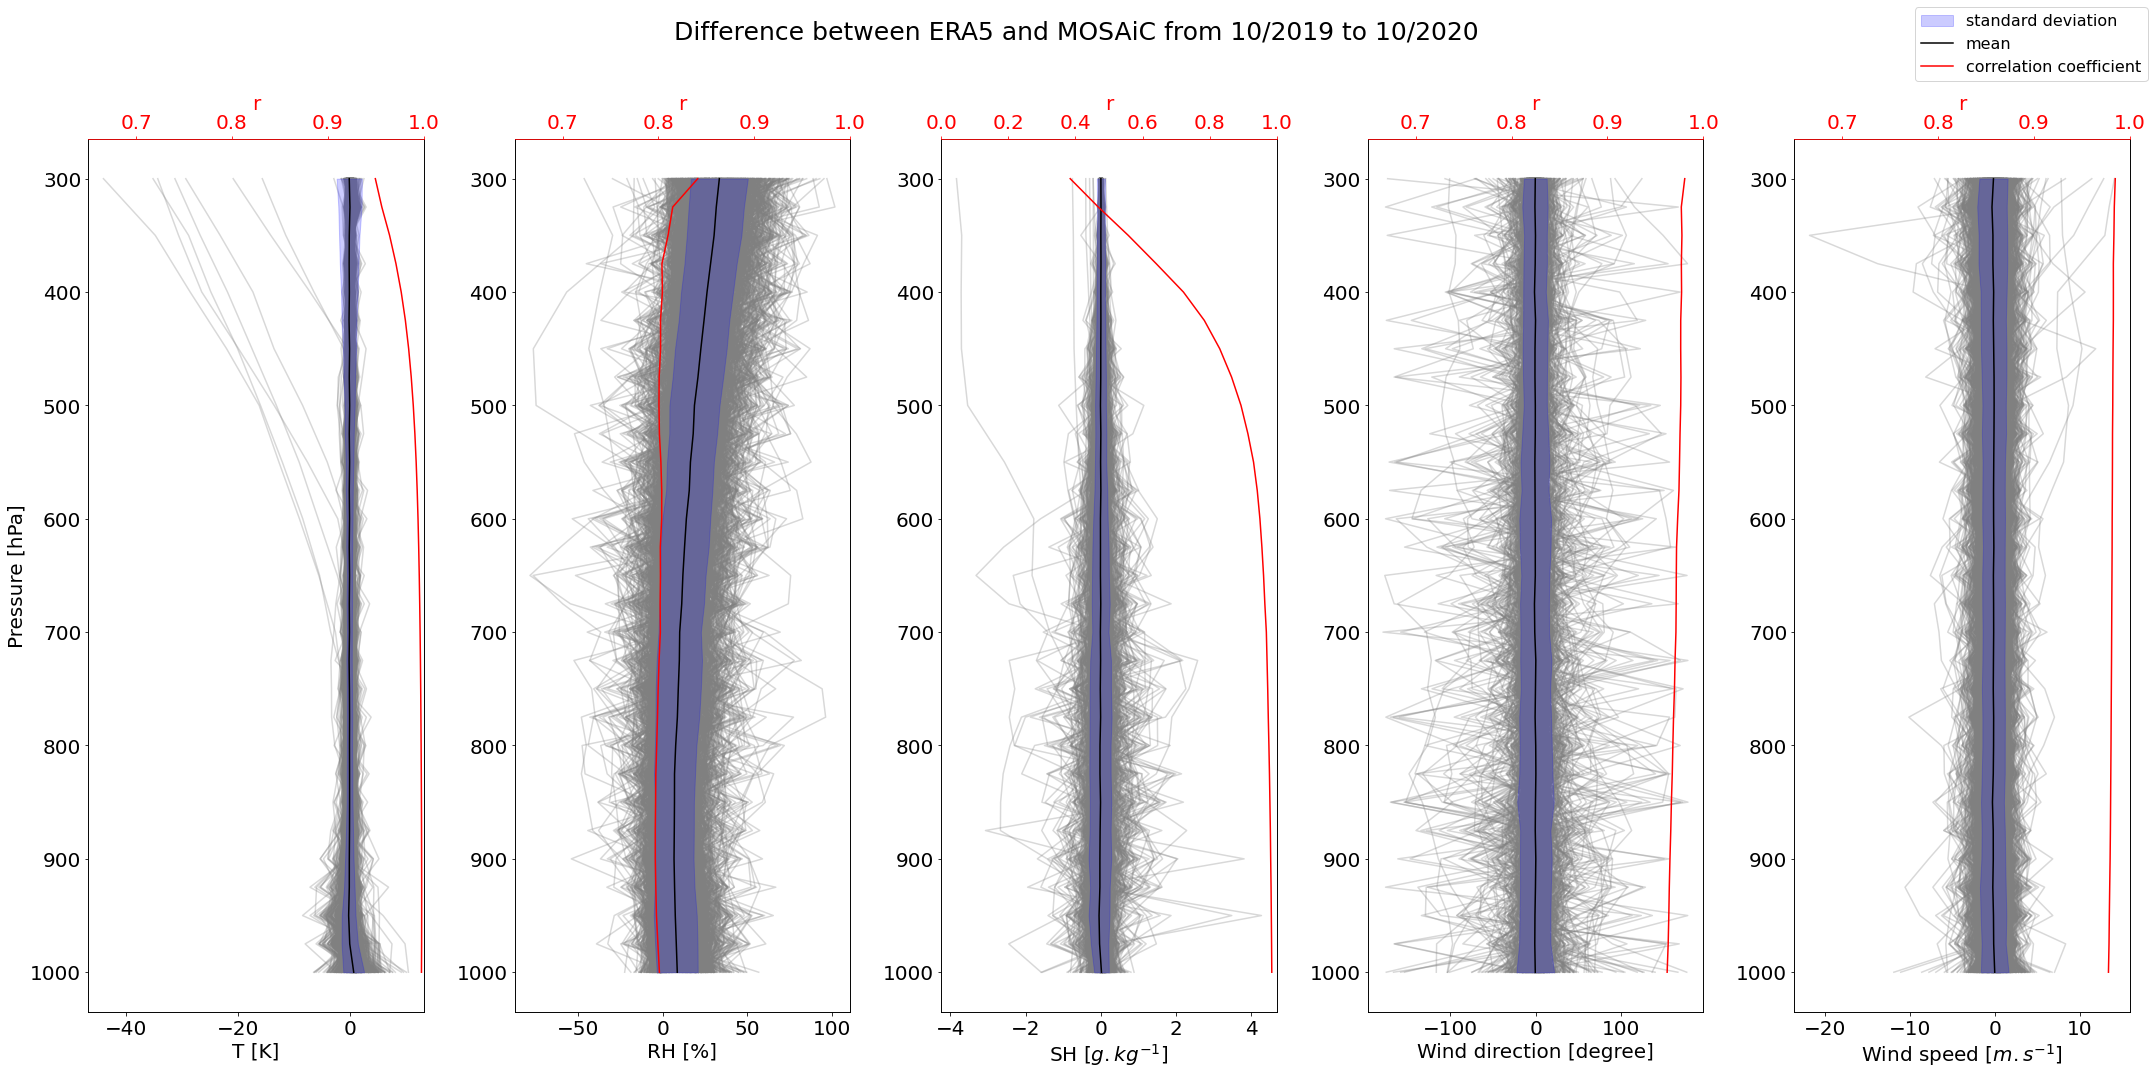

In [25]:
plotbiases() #comment this line to not plot figures
#positive = surestimation in ERA5